In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import integrate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [8]:
area_colors = {
    'MO': (31/255, 157/255, 90/255), # [31, 157, 90] 'blue'
    'ACA': (64/255, 166/255, 102/255), # [64, 166, 102] 'deepskyblue'
    'SS': (24/255, 128/255, 100/255), # [24, 128, 100] 'blueviolet'
    'VIS': (8/255, 133/255, 140/255), # [8, 133, 140] 'green'
    'MO-TH': (255/255, 112/255, 128/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [9]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }
state_colors = {
    'resting': 'royalblue',
    'running': 'seagreen',
    'anesthetized': 'indianred',
}

In [61]:
## define colors for CB readers
CBorange = (230/255, 159/255, 0/255)
CBbgreen = (0/255, 158/255, 115/255)

#### Functions

In [10]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [11]:
def p_stars(test_pval):
    if test_pval < 0.001:
        return '***'
    elif test_pval < 0.01:
        return '**'
    elif test_pval < 0.05:
        return '*'
    else:
        return 'n.s.'

## Load subjects from file

In [12]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [13]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
 551397
Experiment type: electrical and sensory stimulation
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
 586466
Experiment type: electrical and sensory stimulation
 590479
Experiment type: electrical stimulation
 590480
Experiment type: electrical and sensory stimulation
 599017
Experiment type: electrical and sensory stimulation

SSp_deep

 569073
Experiment type: electr

In [14]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'
# Gplotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GRC2022_poster'

## All subjects

In [15]:
## Parameters ##
sigalpha = 0.01

ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
celltype = 'RS'
time_bin = 0.01 # size of time bins (s)

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

auc_window = [0.0, 2.0]
nshuff = 1000 # how many shuffles to do

response_window = {
    'early': [0.002, 0.025],
    'mid': [0.025, 0.15],
    'late': [0.15, 0.3],
}

example_mouse = {
    'MOs_deep': '571619',
}

In [16]:
## Compares response AUC to baseline AUC, no shuffling ##
example_traces = {}
all_subs_auc_stats = []
all_subs_sig_units = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        
        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue

        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        timex = bins[:-1] + time_bin/2
        
        ## Load LFP info and traces ##
        with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
            LFPinfo = json.load(info_file)
        LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
        
        ## Load region LFP traces ONLY for regions with units AND LFP ##
        reg_allLFPtraces = {}
        reg_unit_info = {}
        for region in ctx_regions:
            regdf = unit_info[(unit_info['cell_type'] == celltype) & (unit_info['parent'] == region)]
            if (len(regdf) > 8) and (region in LFPinfo.keys()):
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
                reg_allLFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
            else:
                print('  {}: n={:d} -> not enough units, excluding'.format(region, len(regdf)))
        if len(reg_allLFPtraces) == 0:
            print('  Subject has no regions to analyze.\n')
            continue
        
        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in ['awake', 'anesthetized']:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][statei] = np.concatenate(state_events)
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)
        
        LFP_traces = {}
        unit_traces = {}
        print('  Getting LFP and unit stats...')
        for leveli, states_events in all_event_inds.items():
            LFP_traces[leveli] = {}
            unit_traces[leveli] = {}
            for statei, event_inds in states_events.items():
                LFP_traces[leveli][statei] = {}
                unit_traces[leveli][statei] = {}

                for region in reg_allLFPtraces.keys():
                    stim_ctx = region == stim_area
                    
                    ## Get evoked LFP traces ##
                    ch_areas = np.array(LFPinfo[region]['ch_areas'])
                    layer_mask = np.array([False if '1' in x else True for x in ch_areas])
                    LFPtraces = np.mean(reg_allLFPtraces[region][:, :, event_inds], axis=2)[:, layer_mask]
                    LFP_traces[leveli][statei][region] = [LFP_event_ts, LFPtraces]
                    ## Get AUC ##
                    pop_LFP = np.mean(np.abs(LFPtraces), axis=1)
                    pop_LFP_zscore = (pop_LFP - np.mean(pop_LFP[LFP_event_ts < 0])) / np.std(pop_LFP[LFP_event_ts < 0])
                    lfpinds = np.nonzero((LFP_event_ts > auc_window[0]) & (LFP_event_ts < auc_window[1]))[0]
                    bllfpinds = np.nonzero((LFP_event_ts > -auc_window[1]) & (LFP_event_ts < -auc_window[0]))[0]
                    lfpauc = integrate.simps(np.abs(pop_LFP_zscore)[lfpinds], LFP_event_ts[lfpinds], axis=0, even='last')
                    bllfpauc = integrate.simps(np.abs(pop_LFP_zscore)[bllfpinds], LFP_event_ts[bllfpinds], axis=0, even='last')
                    ## Get p-value ##
                    LFPk, LFPpval = stats.ks_2samp(np.abs(pop_LFP_zscore)[lfpinds], np.abs(pop_LFP_zscore)[bllfpinds])
                    
                    ## Get unit firing rates ##
                    all_firing_rates = np.empty((len(timex), len(reg_unit_info[region]), len(event_inds))) * np.nan
                    for uni, uniti in enumerate(reg_unit_info[region]['unit_id'].values):
                        for ii, evi in enumerate(event_inds):
                            spikecounts, edges = np.histogram(all_unit_event_spikes['event_spikes'][uniti][evi], bins)
                            all_firing_rates[:, uni, ii] = spikecounts / time_bin
                    unittraces = np.mean(all_firing_rates, axis=2)
                    unit_traces[leveli][statei][region] = [timex, unittraces]
                    ## Get AUC ##
                    pop_avg = np.mean(unittraces, axis=1)
                    pop_zscore = (pop_avg - np.mean(pop_avg[timex < 0])) / np.std(pop_avg[timex < 0])
                    uinds = np.nonzero((timex > auc_window[0]) & (timex < auc_window[1]))[0]
                    unitauc = integrate.simps(np.abs(pop_zscore)[uinds], timex[uinds], axis=0, even='last')
                    bluinds = np.nonzero((timex > -auc_window[1]) & (timex < -auc_window[0]))[0]
                    blunitauc = integrate.simps(np.abs(pop_zscore)[bluinds], timex[bluinds], axis=0, even='last')
                    ## Get p-value ##
                    unitk, unitpval = stats.ks_2samp(np.abs(pop_zscore)[uinds], np.abs(pop_zscore)[bluinds])
                    
                    ## Store stats ##
                    all_subs_auc_stats.append([
                        group, mouse_num, stim_area, stim_depth, region, stim_ctx, LFPtraces.shape[1], unittraces.shape[1],
                        leveli, statei, LFPpval, lfpauc/bllfpauc, unitpval, unitauc/blunitauc
                    ])
        
        if (group in example_mouse.keys()) and (mouse_num == example_mouse[group]):
            example_traces['LFP'] = LFP_traces
            example_traces['POPFR'] = unit_traces
        del unit_info, all_unit_event_spikes, stim_log, LFPinfo, reg_allLFPtraces, reg_unit_info, LFP_traces, unit_traces
    print('')
## Create stats dataframe ##
all_subs_auc_df = pd.DataFrame(all_subs_auc_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'region', 'stim_cortex', 'num_chs', 'num_units', 'stim_level', 'state',
    'LFP_p', 'LFPmag', 'POPFR_p', 'POPFRmag'
])

MOs_superficial

 575102
  SS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 571619
  Getting LFP and unit stats...

MOs_deep

 546655
  ACA: n=0 -> not enough units, excluding
  SS: n=0 -> not enough units, excluding
  VIS: n=5 -> not enough units, excluding
  Getting LFP and unit stats...
 551399
  VIS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 551397
  VIS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 569062
  VIS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 569068
  ACA: n=2 -> not enough units, excluding
  VIS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 569069
  SS: n=0 -> not enough units, excluding
  Getting LFP and unit stats...
 569064
  SS: n=3 -> not enough units, excluding
  Getting LFP and unit stats...
 569073
  Getting LFP and unit stats...
 571619
  Getting LFP and unit stats...

SSp_superficial

 571620
  Getting LFP and unit stats...
 586466
  VIS: n

In [46]:
all_subs_auc_df.head()

,group,mouse,stim_area,stim_depth,region,stim_cortex,num_chs,num_units,stim_level,state,LFP_p,LFPmag,POPFR_p,POPFRmag,subject
0,MOs_superficial,575102,MO,superficial,MO,True,95,12,low,awake,2.640282e-48,3.596805,0.039562,1.517146,575102_MOs_superficial
1,MOs_superficial,575102,MO,superficial,ACA,False,60,27,low,awake,2.833413e-15,2.903655,0.964652,0.981013,575102_MOs_superficial
2,MOs_superficial,575102,MO,superficial,VIS,False,152,59,low,awake,4.725449e-21,1.338578,0.466286,1.084758,575102_MOs_superficial
3,MOs_superficial,575102,MO,superficial,MO,True,95,12,low,resting,6.061668e-19,3.363545,0.052139,1.437067,575102_MOs_superficial
4,MOs_superficial,575102,MO,superficial,ACA,False,60,27,low,resting,6.218708e-18,3.125702,0.712582,0.958097,575102_MOs_superficial


In [45]:
all_subs_auc_df['subject'] = all_subs_auc_df.apply(lambda row: row['mouse'] + '_' + row['group'], axis=1)
all_subs_auc_df['LFPsig'] = all_subs_auc_df.apply(lambda row: row['LFP_p'] < sigalpha, axis=1)
all_subs_auc_df['POPsig'] = all_subs_auc_df.apply(lambda row: row['POPFR_p'] < sigalpha, axis=1)
# all_subs_auc_df.head()

In [49]:
len(np.unique(all_subs_auc_df['subject'].values))

23

In [22]:
total_subjects = 0
for groupi in multi_sub_dict.keys():
    groupdf = all_subs_auc_df[(all_subs_auc_df['group'] == groupi)]
    gsubjects = np.unique(groupdf['mouse'].values)
#     print(subjects)
    total_subjects += len(gsubjects)
print('Total subjects included in Figure 3: N={:d} mice'.format(total_subjects))

Total subjects included in Figure 3: N=23 mice


In [23]:
for depthi in ['superficial', 'deep']:
    depthdf = all_subs_auc_df[(all_subs_auc_df['stim_depth'] == depthi)]
    print('{} stim: N={:d} mice'.format(depthi, len(np.unique(depthdf['subject'].values))))

superficial stim: N=7 mice
deep stim: N=16 mice


## Make figure 3

<IPython.core.display.Javascript object>


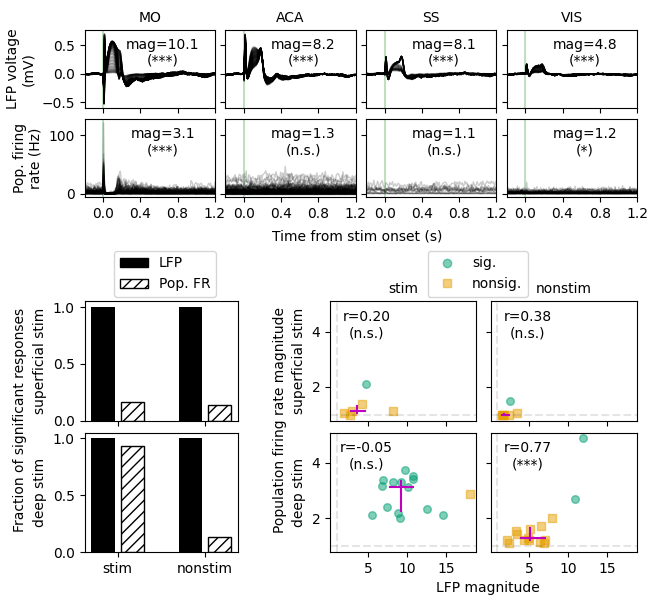

superficial stim: 1/6 stim subjects
 LFP: median=3.60, [2.78, 4.58]
 POP spiking: median=1.12, [1.06, 1.32]
superficial stim: 1/7 nonstim subjects
 LFP: median=1.86, [1.61, 2.48]
 POP spiking: median=1.00, [0.99, 1.04]
deep stim: 14/15 stim subjects
 LFP: median=9.20, [7.78, 10.79]
 POP spiking: median=3.13, [2.25, 3.35]
deep stim: 2/15 nonstim subjects
 LFP: median=5.13, [3.98, 7.01]
 POP spiking: median=1.27, [1.21, 1.66]


In [68]:
plot_stim = 'medium'
plot_state = 'awake'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, 'g', '*', 100], 'nonstim': [False, 'k', 'o', 50]}
comp = {'excited': 'firebrick', 'inhibited': 'mediumblue'}
plot_win = [-0.2, 1.2]
locs1 = np.arange(len(ctx_stim) * (len(comp) + 1)).reshape((len(ctx_stim), (len(comp) + 1)))
plot_regs = example_traces['LFP'][plot_stim][plot_state].keys()
example_df = all_subs_auc_df[
    (all_subs_auc_df['group'] == list(example_mouse.keys())[0]) &
    (all_subs_auc_df['mouse'] == example_mouse[list(example_mouse.keys())[0]]) &
    (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['state'] == plot_state)
]

## Plot params ##
tracetext = (0.6, 0.9)
#####

fig = plt.figure(figsize=(6.5, 6))
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.13, right=0.98, top=0.95, bottom=0.08, height_ratios=[2,3], hspace=0.5)
tracegs = gs[0].subgridspec(ncols=1, nrows=2, hspace=0.15)
LFPgs = tracegs[0].subgridspec(ncols=len(plot_regs), nrows=1, wspace=0.08)
POPgs = tracegs[1].subgridspec(ncols=len(plot_regs), nrows=1, wspace=0.08)
metricgs = gs[1].subgridspec(ncols=2, nrows=1, wspace=0.4, width_ratios=[1,2])
FRgs = metricgs[0].subgridspec(ncols=1, nrows=2, hspace=0.1, wspace=0.1)
FRaxs = [fig.add_subplot(ss) for ss in FRgs]
AUCgs = metricgs[1].subgridspec(ncols=2, nrows=2, hspace=0.1, wspace=0.1)

LFPaxs = []
POPaxs = []
for ii, regi in enumerate(plot_regs):
    if ii == 0:
        LFPaxs.append(fig.add_subplot(LFPgs[ii]))
        POPaxs.append(fig.add_subplot(POPgs[ii]))
    else:
        LFPaxs.append(fig.add_subplot(LFPgs[ii], sharex=LFPaxs[0], sharey=LFPaxs[0]))
        plt.setp(LFPaxs[ii].get_yticklabels(), visible=False)
        POPaxs.append(fig.add_subplot(POPgs[ii], sharex=POPaxs[0], sharey=POPaxs[0]))
        plt.setp(POPaxs[ii].get_yticklabels(), visible=False)
    LFPtime = example_traces['LFP'][plot_stim][plot_state][regi][0]
    LFPtraces = example_traces['LFP'][plot_stim][plot_state][regi][1] * 1E-3
    LFPaxs[ii].axvline(0, color='g', alpha=0.25)
    LFPaxs[ii].plot(LFPtime, LFPtraces, color='k', linewidth=1, alpha=0.2)
    LFPaxs[ii].set_title(regi)
    LFPaxs[ii].set_xlim(plot_win)
    LFPaxs[ii].set_xticks(np.arange(0, plot_win[1]+0.1, 0.4))
    LFPaxs[ii].set_xticklabels([])
    LFPpval = example_df['LFP_p'][example_df['region'] == regi].values[0]
    LFPmag = example_df['LFPmag'][example_df['region'] == regi].values[0]
    LFPaxs[ii].annotate(
        'mag={:.1f}\n({})'.format(LFPmag, p_stars(LFPpval)), xy=tracetext, xycoords='axes fraction', ha='center', va='top'
    )
   
    POPtime = example_traces['POPFR'][plot_stim][plot_state][regi][0]
    POPtraces = example_traces['POPFR'][plot_stim][plot_state][regi][1]
    POPaxs[ii].axvline(0, color='g', alpha=0.25)
    POPaxs[ii].plot(POPtime, POPtraces, color='k', linewidth=1, alpha=0.2)
    POPaxs[ii].set_xlim(plot_win)
    POPaxs[ii].set_xticks(np.arange(0, plot_win[1]+0.1, 0.4))
    POPpval = example_df['POPFR_p'][example_df['region'] == regi].values[0]
    POPmag = example_df['POPFRmag'][example_df['region'] == regi].values[0]
    POPaxs[ii].annotate(
        'mag={:.1f}\n({})'.format(POPmag, p_stars(POPpval)), xy=tracetext, xycoords='axes fraction', ha='center', va='top'
    )
    
LFPaxs[0].set_ylabel('LFP voltage\n(mV)')
POPaxs[0].set_ylabel('Pop. firing\nrate (Hz)')
fig.text(0.55, 0.6, 'Time from stim onset (s)', ha='center')

AUCaxs = []
for rowi, depthi in enumerate(compare):
    for coli, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
        if (rowi == 0) & (coli == 0):
            AUCax = fig.add_subplot(AUCgs[rowi, coli])
            AUCaxs.append(AUCax)
        else:
            AUCax = fig.add_subplot(AUCgs[rowi, coli], sharex=AUCaxs[0], sharey=AUCaxs[0])
            AUCaxs.append(AUCax)
        
        AUCax.axvline(1, color='k', linestyle='dashed', alpha=0.1)
        AUCax.axhline(1, color='k', linestyle='dashed', alpha=0.1)
        dfmean = all_subs_auc_df[
            (all_subs_auc_df['stim_depth'] == depthi) & (all_subs_auc_df['state'] == plot_state) &
            (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['stim_cortex'] == stiminfo[0])
        ].groupby(['subject']).mean()
        dfall = all_subs_auc_df[
            (all_subs_auc_df['stim_depth'] == depthi) & (all_subs_auc_df['state'] == plot_state) &
            (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['stim_cortex'] == stiminfo[0])
        ].groupby(['subject']).all()
        print('{} stim: {:d}/{:d} {} subjects'.format(
            depthi, np.sum(dfall['POPsig'].values), len(dfmean), stimlabel))
        sigmask = dfall['LFPsig'].values * dfall['POPsig'].values
        AUCax.scatter(
            dfmean['LFPmag'].values[sigmask], dfmean['POPFRmag'].values[sigmask], color=CBbgreen, marker='o', s=30, alpha=0.5)
        AUCax.scatter(
            dfmean['LFPmag'].values[~sigmask], dfmean['POPFRmag'].values[~sigmask], color=CBorange, marker='s', s=30, alpha=0.5)
        ## Add median and quartile error bars ##
        AUCax.plot(
            np.repeat(np.median(dfmean['LFPmag'].values), 2), np.percentile(dfmean['POPFRmag'].values, [25, 75]), color='m')
        AUCax.plot(
            np.percentile(dfmean['LFPmag'].values, [25, 75]), np.repeat(np.median(dfmean['POPFRmag'].values), 2), color='m')
        print(' LFP: median={:.2f}, [{:.2f}, {:.2f}]'.format(np.median(dfmean['LFPmag'].values),
            np.percentile(dfmean['LFPmag'].values,25), np.percentile(dfmean['LFPmag'].values,75)))
        print(' POP spiking: median={:.2f}, [{:.2f}, {:.2f}]'.format(np.median(dfmean['POPFRmag'].values),
            np.percentile(dfmean['POPFRmag'].values,25), np.percentile(dfmean['POPFRmag'].values,75)))
        ## Linear regression ##
        res = stats.linregress(dfmean['LFPmag'].values, dfmean['POPFRmag'].values)
        AUCax.annotate(
            'r={:.2f}\n({})'.format(res.rvalue, p_stars(res.pvalue)), xy=(0.25, 0.8),
            xycoords='axes fraction', ha='center', va='center'
        )
        if rowi == 0:
            AUCax.set_title(stimlabel)
            plt.setp(AUCax.get_xticklabels(), visible=False)
        if coli == 0:
            AUCax.set_ylabel('{} stim'.format(depthi))
            FRaxs[rowi].set_ylabel('{} stim'.format(depthi))
        else:
            plt.setp(AUCax.get_yticklabels(), visible=False)
        
        fractLFP = np.sum(dfall['LFPsig'].values) / len(dfmean)
        fractPOP = np.sum(dfall['POPsig'].values) / len(dfmean)
        
        FRaxs[rowi].bar(locs1[coli, 0], fractLFP, color='k')
        FRaxs[rowi].bar(locs1[coli, 1], fractPOP, color='w', edgecolor='k', hatch='///')
        FRaxs[rowi].set_xticks(np.mean(locs1[:, :-1], axis=1))
plt.setp(FRaxs[0].get_xticklabels(), visible=False)
FRaxs[1].set_xticklabels(ctx_stim.keys())

## Add legends ##
barleg = [
    Patch(facecolor='k', edgecolor='k', label='LFP'),
    Patch(facecolor='w', edgecolor='k', hatch='///', label='Pop. FR'),
]
FRaxs[0].legend(handles=barleg, bbox_to_anchor=(0.15, 0.98))
AUCleg = [
    Line2D([0], [0], linestyle='none', color=CBbgreen, marker='o', alpha=0.5, label='sig.'),
    Line2D([0], [0], linestyle='none', color=CBorange, marker='s', alpha=0.5, label='nonsig.')
]
AUCaxs[0].legend(handles=AUCleg, bbox_to_anchor=(0.62, 0.98), loc='lower left')                

## Axes labels ##
fig.text(0.42, 0.3, 'Population firing rate magnitude', va='center', rotation='vertical')
fig.text(0.67, 0.02, 'LFP magnitude', va='center')
fig.text(0.02, 0.3, 'Fraction of significant responses', va='center', rotation='vertical')

## Save ##
figname = 'Fig3_v6_{}_{}.png'.format(plot_state, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

#### Plot the LFP-units comparison only

<IPython.core.display.Javascript object>


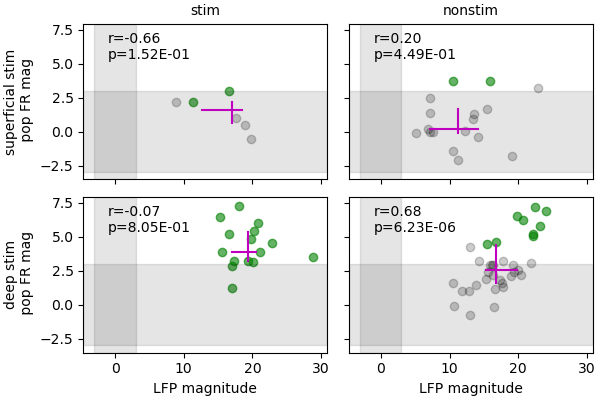

In [50]:
plot_stim = 'medium'
plot_state = 'resting'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, 'g', '*', 100], 'nonstim': [False, 'k', 'o', 50]}
locs1 = np.arange(len(ctx_stim) * (len(comp) + 1)).reshape((len(ctx_stim), (len(comp) + 1)))
plot_regs = example_traces['LFP'][plot_stim][plot_state].keys()
example_df = all_subs_auc_df[
    (all_subs_auc_df['group'] == list(example_mouse.keys())[0]) &
    (all_subs_auc_df['mouse'] == example_mouse[list(example_mouse.keys())[0]]) &
    (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['state'] == plot_state)
]

fig, axs = plt.subplots(
    nrows=len(compare), ncols=len(ctx_stim), figsize=(6, 4), sharex=True, sharey=True, constrained_layout=True)

for rowi, depthi in enumerate(compare):
    for coli, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
#         axs[rowi, coli].axvline(1, color='k', linewidth=1, linestyle='dashed', alpha=0.5)
#         axs[rowi, coli].axhline(1, color='k', linewidth=1, linestyle='dashed', alpha=0.5)
        axs[rowi, coli].axvspan(-3, 3, color='k', alpha=0.1)
        axs[rowi, coli].axhspan(-3, 3, color='k', alpha=0.1)
        
        dfa = all_subs_auc_df[
            (all_subs_auc_df['stim_depth'] == depthi) & (all_subs_auc_df['state'] == plot_state) &
            (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['stim_cortex'] == stiminfo[0])
        ]
#         axs[rowi, coli].scatter(
#             dfa['LFPmag'].values, dfa['POPFRmag'].values, c='b', marker='o', alpha=0.4
#         )
        sigmask = (dfa['LFP_p'].values < sigalpha) * (dfa['POPFR_p'].values < sigalpha)
        axs[rowi, coli].scatter(
            dfa['LFPmag'].values[sigmask], dfa['POPFRmag'].values[sigmask], c='g', marker='o', alpha=0.6
        )
        axs[rowi, coli].scatter(
            dfa['LFPmag'].values[~sigmask], dfa['POPFRmag'].values[~sigmask], c='k', marker='o', alpha=0.2
        )
        
        ## Add median and quartile error bars ##
        axs[rowi, coli].plot(
            np.repeat(np.median(dfa['LFPmag'].values), 2), np.percentile(dfa['POPFRmag'].values, [25, 75]), color='m'
        )
        axs[rowi, coli].plot(
            np.percentile(dfa['LFPmag'].values, [25, 75]), np.repeat(np.median(dfa['POPFRmag'].values), 2), color='m'
        )
        
        
        ## Linear regression ##
        res = stats.linregress(dfa['LFPmag'].values, dfa['POPFRmag'].values)
        axs[rowi, coli].annotate(
            'r={:.2f}\np={:.3f}'.format(res.rvalue, res.pvalue), xy=(0.1, 0.85), xycoords='axes fraction',
            ha='left', va='center'
        )
#         if res.pvalue < sigalpha:
#             axs[rowi, coli]
        

        if rowi == 1:
            axs[rowi, coli].set_xlabel('LFP magnitude')
        else:
            axs[rowi, coli].set_title(stimlabel)
        
        if coli == 0:
            axs[rowi, coli].set_ylabel('{} stim\n pop FR mag'.format(depthi))

<IPython.core.display.Javascript object>


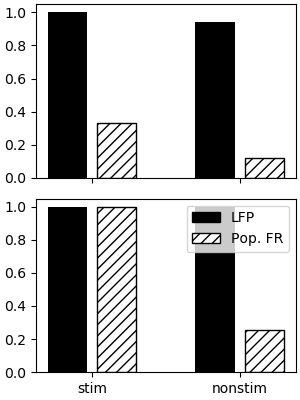

In [99]:
plot_stim = 'medium'
plot_state = 'resting'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, 'g', '*', 100], 'nonstim': [False, 'k', 'o', 50]}
locs1 = np.arange(len(ctx_stim) * (len(comp) + 1)).reshape((len(ctx_stim), (len(comp) + 1)))
plot_regs = example_traces['LFP'][plot_stim][plot_state].keys()
example_df = all_subs_auc_df[
    (all_subs_auc_df['group'] == list(example_mouse.keys())[0]) &
    (all_subs_auc_df['mouse'] == example_mouse[list(example_mouse.keys())[0]]) &
    (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['state'] == plot_state)
]

fig, axs = plt.subplots(
    nrows=len(compare), ncols=1, figsize=(3, 4), sharex=True, sharey=True, constrained_layout=True)

for rowi, depthi in enumerate(compare):
    for coli, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
        dfa = all_subs_auc_df[
            (all_subs_auc_df['stim_depth'] == depthi) & (all_subs_auc_df['state'] == plot_state) &
            (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['stim_cortex'] == stiminfo[0])
        ]
        
        fractLFP = np.sum(dfa['LFP_p'].values < sigalpha) / len(dfa)
        fractPOP = np.sum(dfa['POPFR_p'].values < sigalpha) / len(dfa)
        
        axs[rowi].bar(locs1[coli, 0], fractLFP, color='k')
        axs[rowi].bar(locs1[coli, 1], fractPOP, color='w', edgecolor='k', hatch='///')
#         axs[rowi].set_ylabel('Fraction of significant responses')
        
axs[1].set_xticks(np.mean(locs1[:, :-1], axis=1))
axs[1].set_xticklabels(ctx_stim.keys())

## Make a legend ##
barleg = [
    Patch(facecolor='k', edgecolor='k', label='LFP'),
    Patch(facecolor='w', edgecolor='k', hatch='///', label='Pop. FR'),
]
axs[1].legend(handles=barleg)

Original analysis and figure